In [1]:
from fastai.text import *
from fasttext import FastText
from gensim.models import KeyedVectors
import torch
import torch.nn as nn
from torchcrf import CRF
import string
from typing import List, Optional
from conlleval import evaluate
from fastai.callbacks.tracker import EarlyStoppingCallback, SaveModelCallback

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
PAD, UNK, NUM, PUNCT = '<PAD>', '<UNK>', '<NUM>', '<PUNCT>'
CHARACTERS = '‘ẹjO:òồọðỡụẽÂưiŨdỜ”ẦVMẩCệ“+v!ỹỉPt2/lứỄỐƠúằíỔẢắDqữ?SJỳẳấwƯ*ẫQơ3éeĩTÔuỲbâựỰÐể0ùừWợBô²èá4êỷÍỖRL,ộ9ynf%g~³¼ẤỗHIG6Ệử°Yậổx(Ởra&Ẩẵễóở)Đm>Áềẻ;sàỮõẬăỵủkỦì]_Ạ7–ÕNãịố8hỪ…\'[Eớ.ạũếXĂờUỒÝỨảpÀầặ1đcýÚ’zÊỏẶoKZ5"FA-'
TAGS = ['B-MISC', 'I-MISC', 'B-PER', 'O', 'B-LOC', 'I-PER', 'B-ORG', 'I-ORG', 'I-LOC']
POSES = ['R', 'Nc', 'Vy', 'M', 'A', 'Z', 'N', 'CH', 'Ny', 'Nu', 'C', 'V', 'L', 'I', 'P', 'Np', 'T', 'FW', 'X', 'E']
CHUNKS = ['B-VP', 'B-AP', 'B-PP', 'I-AP', 'B-NP', 'O', 'I-VP', 'I-NP']

In [4]:
def load_pretrained_vocab_embedding(type: str, path):
    def load_pretrained_embedding_from_fasttext_cc_model(path):
        model = FastText.load_model(path)

        embedding_dim = model.get_dimension()
        words = [UNK, PAD, *model.words, NUM, PUNCT]
        vocab = Vocab(words)
        embeddings = nn.Embedding.from_pretrained(
            torch.cat([
                (torch.rand(1, embedding_dim,dtype=torch.float)
                 .uniform_(- math.sqrt(3 / embedding_dim),math.sqrt(3 / embedding_dim))),
                torch.zeros(1, embedding_dim,dtype=torch.float),
                torch.tensor(model.get_input_matrix()),
                (torch.rand(2, embedding_dim,dtype=torch.float)
                 .uniform_(- math.sqrt(3 / embedding_dim),math.sqrt(3 / embedding_dim)))       
            ]),
            padding_idx=vocab.stoi[PAD]
        )
        return vocab, embeddings
            

    def load_pretrained_embedding_from_gensim_fasttext_model(path):
        model = KeyedVectors.load_word2vec_format(path, binary=True)
        embedding_dim = model.vector_size
        words = [UNK, PAD, *model.index2word, NUM, PUNCT]
        vocab = Vocab(words)
        embeddings = nn.Embedding.from_pretrained(
            torch.cat([
                (torch.rand(1, embedding_dim, dtype=torch.float)
                                 .uniform_(- math.sqrt(3 / embedding_dim),math.sqrt(3 / embedding_dim))),
                torch.zeros(1, embedding_dim, dtype=torch.float)
                torch.tensor(model.vectors),
                (torch.rand(2, embedding_dim, dtype=torch.float)
                 .uniform_(- math.sqrt(3 / embedding_dim),math.sqrt(3 / embedding_dim)))
            ]),
            padding_idx=vocab.stoi[PAD]
        )
        return vocab, embeddings
    
    assert type in ['fasttext_cc', 'fasttext_gensim']
    if type == 'fasttext_cc':
        return load_pretrained_embedding_from_fasttext_cc_model(path)
    else:
        return load_pretrained_embedding_from_gensim_fasttext_model(path)

In [5]:
class WordVocab(Vocab):
    def numericalize(self, t:Collection[str]) -> List[int]:
        return [self.stoi[self.process_word(w)] for w in t]
    
    @staticmethod
    def process_word(word: str, lowercase=True):
        if lowercase:
            word = word.lower()
        if word[0].isdigit():
            return NUM
        if word[0] in string.punctuation:
            return PUNCT
        return word

In [6]:
character_vocab = WordVocab([UNK, PAD, *CHARACTERS])
pos_vocab = Vocab([PAD, *POSES])
chunk_vocab = Vocab([PAD, *CHUNKS])
# tag_vocab = Vocab([*TAGS, PAD])
tag_vocab = Vocab(TAGS)
word_vocab, emb = load_pretrained_vocab_embedding(
    type='fasttext_cc',
    path='data/pretrained_embedding/fasttext_pretrained_embeddings_300.bin'
)

In [7]:
def read_data(fn):
    sentences = []
    tag_sentences = []
    sentence = []
    tag_sentence = []
    with open(fn, mode='r', encoding='utf8') as f:
        for line in f:
            stripped_line = line.strip()
            if stripped_line:
                tokens = line.split()
                if len(tokens) == 4:
                    sentence.append(tuple(tokens[:3]))
                    tag_sentence.append(tokens[-1])
            else:
                sentences.append(sentence)
                tag_sentences.append(tag_sentence)
                sentence = []
                tag_sentence = []
        if len(sentence) > 0:
            sentences.append(sentence)
            tag_sentences.append(tag_sentence)
        f.close()
    
    return sentences, tag_sentences


In [8]:
train_sentences, train_tags = read_data('data/data/train.txt')
dev_sentences, dev_tags = read_data('data/data/dev.txt')
test_sentences, test_tags = read_data('data/data/test.txt')

In [9]:
class TagPreProcessor(PreProcessor):
    def __init__(
            self,
            tag_vocab: Vocab
    ):
        super(TagPreProcessor, self).__init__()
        self.tag_vocab = tag_vocab

    def process_one(self, tag:Any):
        return self.tag_vocab.numericalize(tag)
    

class SentencePreProcessor(PreProcessor):
    def __init__(
            self, 
            character_vocab: Vocab, 
            pos_vocab: Vocab, 
            chunk_vocab: Vocab, 
            # tag_vocab: Vocab,
            word_vocab: Vocab,
            ds: Collection=None
    ):
        super(SentencePreProcessor, self).__init__(ds=ds)
        self.character_vocab = character_vocab
        self.pos_vocab = pos_vocab
        self.chunk_vocab = chunk_vocab
        # self.tag_vocab = tag_vocab
        self.word_vocab = word_vocab
    
    def process_one(self, sentence:Any):
        words, poses, chunks = zip(*sentence)
        
        word_indices = self.word_vocab.numericalize([word.lower() for word in words])
        pos_indices = self.pos_vocab.numericalize(poses)
        chunk_indices = self.chunk_vocab.numericalize(chunks)
        # tag_indices = self.tag_vocab.numericalize(tags)
        character_indices = [
            self.character_vocab.numericalize(word) for word in words
        ]
        
        return word_indices, character_indices, pos_indices, chunk_indices

In [10]:
sentence_processor = SentencePreProcessor(
    character_vocab=character_vocab,
    pos_vocab=pos_vocab,
    chunk_vocab=chunk_vocab,
    # tag_vocab=tag_vocab,
    word_vocab=word_vocab
)

train_il = ItemList(
    items=train_sentences,
    processor=sentence_processor,
).process()

dev_il = ItemList(
    items=dev_sentences,
    processor=sentence_processor
).process()

test_il = ItemList(
    items=test_sentences,
    processor=sentence_processor
).process()


In [11]:
tag_processor = TagPreProcessor(tag_vocab=tag_vocab)
train_tl = ItemList(
    items=train_tags,
    processor=tag_processor,
).process()

dev_tl = ItemList(
    items=dev_tags,
    processor=tag_processor,
).process()

test_tl = ItemList(
    items=test_tags,
    processor=tag_processor,
).process()

In [13]:
# test_tl[:2]

In [14]:
train_ll = LabelList(x=train_il, y=train_tl)
dev_ll = LabelList(x=dev_il, y=dev_tl)
test_ll = LabelList(x=test_il, y=test_tl)

In [15]:
# def pad_collate(samples, pad_idx=1, pad_first=False):
#     max_len = max([len(s[0]) for s in samples])
#     res = torch.zeros(len(samples), max_len).long() + pad_idx
#     for i,s in enumerate(samples):
#         if pad_first: res[i, -len(s[0]):] = LongTensor(s[0])
#         else:         res[i, :len(s[0]) ] = LongTensor(s[0])
#     return res, tensor([s[1] for s in samples])
# 
# def padding_collate(samples, pad_idx=1, pad_first=False, sort=False):
#     lengths = [len(s) for s in samples]
#     max_len = max(lengths)
#     res = torch.zeros(len(samples), max_len).long() + pad_idx
#     for i,s in enumerate(samples):
#         if pad_first: res[i, -len(s):] = LongTensor(s)
#         else:         res[i, :len(s) ] = LongTensor(s)
# 
#     if sort:
#         args_sort = torch.tensor(lengths, dtype=torch.long).argsort(descending=True)
#         return res[args_sort], torch.argsort(args_sort)
#     return res
# 
# 
# def collate_fn(batch_data, word_bs=64, pad_first=False):
#     batch_data = sorted(batch_data, key=lambda x: len(x[0][0]), reverse=True)
#     xs, ys = zip(*batch_data)
# 
#     sentences, characters, poses, chunks = zip(*xs)
#     words = sum(characters, [])
# 
#     # pad sentences, poses, chunks 
#     pad_sentences, pad_poses, pad_chunks = padding_collate(sentences), padding_collate(poses), padding_collate(chunks)
# 
#     # pad characters
#     num_words = torch.tensor([len(sentence) for sentence in sentences]).long()
#     num_word_batch = (len(words) - 1) // word_bs + 1
# 
#     pad_word_batches = [
#         padding_collate(words[i * word_bs: (i + 1) * word_bs], sort=True) for i in range(num_word_batch)
#     ]
# 
#     # pad ys
#     pad_tags = padding_collate(ys)
# 
#     return (pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words), pad_tags

class CollateFn:
    def __init__(
            self,
            word_vocab: Vocab,
            character_vocab: Vocab,
            pos_vocab: Vocab,
            chunk_vocab: Vocab,
            tag_vocab: Vocab,
            word_bs=64,
            pad_first=False
    ):
        self.word_vocab = word_vocab
        self.character_vocab = character_vocab
        self.pos_vocab = pos_vocab
        self.chunk_vocab = chunk_vocab
        self.tag_vocab = tag_vocab
        self.word_bs = word_bs
        self.pad_first = pad_first
        
        self.word_pad_idx = self.word_vocab.stoi[PAD]
        self.character_pad_idx = self.character_vocab.stoi[PAD]
        self.pos_pad_idx = self.pos_vocab.stoi[PAD]
        self.chunk_pad_idx = self.chunk_vocab.stoi[PAD]
        self.tag_pad_idx = self.tag_vocab.stoi[PAD]
    
    @staticmethod
    def padding_collate(samples, pad_idx=1, pad_first=False, sort=False):
        lengths = [len(s) for s in samples]
        max_len = max(lengths)
        res = torch.zeros(len(samples), max_len).long() + pad_idx
        for i,s in enumerate(samples):
            if pad_first: res[i, -len(s):] = LongTensor(s)
            else:         res[i, :len(s) ] = LongTensor(s)
        
        if sort:
            args_sort = torch.tensor(lengths, dtype=torch.long).argsort(descending=True)
            return res[args_sort], torch.argsort(args_sort)
        return res
    
    def __call__(self, batch_data):
        batch_data = sorted(batch_data, key=lambda x: len(x[0][0]), reverse=True)
        xs, ys = zip(*batch_data)
        
        sentences, characters, poses, chunks = zip(*xs)
        words = sum(characters, [])
       
        # pad sentences, poses, chunks 
        pad_sentences, pad_poses, pad_chunks = (
            self.padding_collate(sentences, pad_idx=self.word_pad_idx, pad_first=self.pad_first), 
            self.padding_collate(poses, pad_idx=self.pos_pad_idx, pad_first=self.pad_first), 
            self.padding_collate(chunks, pad_idx=self.chunk_pad_idx, pad_first=self.pad_first)
        )
        
        # pad characters
        num_words = torch.tensor([len(sentence) for sentence in sentences]).long()
        num_word_batch = (len(words) - 1) // self.word_bs + 1
        
        pad_word_batches = [
            self.padding_collate(
                words[i * self.word_bs: (i + 1) * self.word_bs], 
                pad_idx=self.character_pad_idx,
                pad_first=self.pad_first,
                sort=True
            ) for i in range(num_word_batch)
        ]
        
        # pad ys
        pad_tags = self.padding_collate(ys, pad_idx=self.tag_pad_idx, pad_first=self.pad_first)
        
        return (pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words), pad_tags
        

In [16]:
databunch = DataBunch.create(
    train_ds=train_ll,
    valid_ds=dev_ll,
    test_ds=test_ll,
    collate_fn=CollateFn(word_vocab, character_vocab, pos_vocab, chunk_vocab,tag_vocab, 64, False),
    bs=8,
    device=DEVICE
)

In [17]:
# (pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words), pad_tags = databunch.one_batch()

# pad_word_batch, recover_indices = pad_word_batches[0]

In [18]:
# print(pad_word_batch, recover_indices)
# bs, sl = pad_word_batch.size()
# mask = pad_word_batch == 1
# lengths = sl - (mask.sum(1))

In [19]:
# embedding = nn.Embedding(num_embeddings=len(character_vocab.stoi), embedding_dim=50, padding_idx=1)

In [20]:
# embs = embedding(pad_word_batch.T)
# embs.size(), nn.utils.rnn.pack_padded_sequence(embs, lengths=lengths)


In [21]:
class CharacterLSTM(nn.Module):
    def __init__(self, vocab: Vocab, embedding_dim, hidden_dim):
        super(CharacterLSTM, self).__init__()
        self.vocab = vocab
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.pad_idx = self.vocab.stoi['<PAD>']
        
        self.embedding = self._init_embedding(
            num_embeddings=len(vocab.itos),
            embedding_dim=embedding_dim,
            pad_idx=self.pad_idx
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True
        )
        
    @staticmethod
    def _trunc_normal_(x: torch.Tensor, mean: float = 0., std: float = 1.) -> torch.Tensor:
        """Truncated normal initialization."""
        # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
        return x.normal_().fmod_(2).mul_(std).add_(mean)
    
    def _init_embedding(self, num_embeddings: int, embedding_dim: int, pad_idx=0) -> nn.Module:
        """Create an embedding layer."""
        emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=pad_idx)
        # See https://arxiv.org/abs/1711.09160
        with torch.no_grad(): self._trunc_normal_(emb.weight, std=0.01)
        return emb
    
    def forward(self, *input: Any, **kwargs: Any):
        pad_word_batches, num_words = input
        max_num_words = num_words.max().item()
        
        batch_outputs = []
        for pad_word_batch, recover_indices in pad_word_batches:
            batch_outputs.append(self.forward_one(pad_word_batch, recover_indices))
        
        outputs = torch.cat(batch_outputs, dim=0).split_with_sizes(num_words.tolist())
        outputs = [
            nn.functional.pad(
                output, pad=[0, 0, 0, max_num_words - output.size(0)], 
                mode='constant', value=0) 
            for output in outputs
        ]
        
        return torch.stack(outputs)
            
    
    def forward_one(self, pad_word_batch, recover_indices):
        bs, sl = pad_word_batch.size()
        mask = pad_word_batch == 1
        lengths = sl - mask.sum(1)
        embs = self.embedding(pad_word_batch)
        embs_packed = nn.utils.rnn.pack_padded_sequence(embs, lengths=lengths, batch_first=True)
        outputs, _ = self.lstm(embs_packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = torch.cat([
            outputs[0, :, :self.hidden_dim],
            outputs[lengths - 1, range(lengths.size(0)), self.hidden_dim:]
        ], dim=1)
        
        return outputs[recover_indices]
        

In [22]:
class ContextLSTM(nn.Module):
    def __init__(
            self,
            word_vocab: Vocab,
            word_embedding_dim,
            context_hidden_dim,
            pretrained_word_embedding: nn.Embedding,
            character_vocab: Vocab,
            character_embedding_dim,
            character_hidden_dim,
            chunk_vocab: Vocab=None,
            pos_vocab: Vocab=None,
            use_pos_chunk=False,
            dropout=0.
    ):
        super(ContextLSTM, self).__init__()
        self.use_pos_chunk = use_pos_chunk
        self.word_vocab = word_vocab
        
        self.chunk_embedding = None
        self.pos_embedding = None
        if use_pos_chunk:
            assert chunk_vocab is not None, 'use_pos_chunk is True, require chunk_vocab'
            assert pos_vocab is not None, 'use_pos_chunk is True, require pos_vocab'
            self.chunk_embedding = self._init_one_hot_embedding(len(chunk_vocab.itos), chunk_vocab.stoi[PAD])
            self.pos_embedding = self._init_one_hot_embedding(len(pos_vocab.itos), pos_vocab.stoi[PAD])
            
        if pretrained_word_embedding is not None:
            self.word_embedding = pretrained_word_embedding
            self.word_embedding_dim = pretrained_word_embedding.embedding_dim
            self.num_word_embeddings = pretrained_word_embedding.num_embeddings
        else:
            self.word_embedding_dim = word_embedding_dim
            self.num_word_embeddings = len(word_vocab.itos)
            self.word_embedding = self._init_embedding(
                num_embeddings=self.num_word_embeddings,
                embedding_dim=word_embedding_dim,
                pad_idx=word_vocab.stoi['<PAD>']
            )
            
        
        self.character_lstm = CharacterLSTM(
            vocab=character_vocab,
            embedding_dim=character_embedding_dim,
            hidden_dim=character_hidden_dim
        )
        
        context_input_dim = (self.word_embedding_dim 
                             + ((len(chunk_vocab.itos) + len(pos_vocab.itos) - 2) if use_pos_chunk else 0)
                             + 2 * character_hidden_dim)
        self.context_lstm = nn.LSTM(
            input_size=context_input_dim,
            hidden_size=context_hidden_dim,
            bidirectional=True
        )
        
        self.dropout = nn.Dropout(p=dropout)
    
    @staticmethod
    def _trunc_normal_(x: torch.Tensor, mean: float = 0., std: float = 1.) -> torch.Tensor:
        """Truncated normal initialization."""
        # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
        return x.normal_().fmod_(2).mul_(std).add_(mean)
    
    def _init_embedding(self, num_embeddings: int, embedding_dim: int, pad_idx=0) -> nn.Module:
        """Create an embedding layer."""
        emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=pad_idx)
        # See https://arxiv.org/abs/1711.09160
        with torch.no_grad(): self._trunc_normal_(emb.weight, std=0.01)
        return emb
    
    @staticmethod
    def _init_one_hot_embedding(vocab_size, pad_idx):
        weights = torch.zeros(vocab_size - 1, vocab_size - 1)
        weights[range(vocab_size - 1), range(vocab_size - 1)] = 1
        weights = torch.cat([weights[:pad_idx], torch.zeros(1, vocab_size - 1), weights[pad_idx:]])
        return nn.Embedding.from_pretrained(weights, freeze=True, padding_idx=pad_idx)
        
    
    def forward(self, *input: Any, **kwargs: Any):
        pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words = input
        
        # word with character level features
        combined_features = [self.character_lstm(pad_word_batches, num_words)]
        
        # pos, chunk feature with one-hot encoding if use pos chunk
        if self.use_pos_chunk:
            combined_features.append(self.pos_embedding(pad_poses))
            combined_features.append(self.chunk_embedding(pad_chunks))
        
        # word embedding features
        combined_features.append(self.word_embedding(pad_sentences))
        
        combined_features = torch.cat(combined_features, dim=2)
        
        # dropout
        combined_features = self.dropout(combined_features)
        
        bs, ls = pad_sentences.size()
        mask = pad_sentences == self.word_vocab.stoi[PAD]
        lengths = ls - mask.sum(1)
        
        packed_combine_features = nn.utils.rnn.pack_padded_sequence(
            combined_features,
            lengths=lengths,
            batch_first=True
        )
        
        packed_outputs, _ = self.context_lstm(packed_combine_features)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        # dropout
        outputs = self.dropout(outputs)
        
        return outputs
        

In [23]:
# context_lstm = ContextLSTM(
#     word_vocab=word_vocab,
#     word_embedding_dim=300,
#     context_hidden_dim=150,
#     pretrained_word_embedding=emb,
#     character_vocab=character_vocab,
#     character_embedding_dim=100,
#     character_hidden_dim=100,
#     chunk_vocab=chunk_vocab,
#     pos_vocab=pos_vocab,
#     use_pos_chunk=True
# )

In [24]:
# context_lstm(pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words).size()

In [25]:
class BiLstmCrf(nn.Module):
    def __init__(
            self,
            word_vocab: Vocab,
            word_embedding_dim: int,
            context_hidden_dim: int,
            pretrained_word_embedding: nn.Embedding,
            character_vocab: Vocab,
            character_embedding_dim: int,
            character_hidden_dim: int,
            tag_vocab: Vocab,
            chunk_vocab=None,
            pos_vocab=None,
            use_pos_chunk=False,
            dropout=0.35
    ):
        super(BiLstmCrf, self).__init__()
        self.tag_vocab = tag_vocab
        self.word_vocab = word_vocab
        self.use_pos_chunk = use_pos_chunk
        self.dropout = dropout
        
        self.context_lstm = ContextLSTM(
            word_vocab=word_vocab,
            word_embedding_dim=word_embedding_dim,
            context_hidden_dim=context_hidden_dim,
            pretrained_word_embedding=pretrained_word_embedding,
            character_vocab=character_vocab,
            character_embedding_dim=character_embedding_dim,
            character_hidden_dim=character_hidden_dim,
            chunk_vocab=chunk_vocab,
            pos_vocab=pos_vocab,
            use_pos_chunk=use_pos_chunk,
            dropout=dropout
        )
        
        # self.hidden2tag = nn.Linear(2 * context_hidden_dim, len(tag_vocab.itos))
        self.hidden2tag = self.get_linear_layer(2 * context_hidden_dim, len(tag_vocab.itos))
        self.crf = CRF(
            num_tags=len(tag_vocab.itos),
            # batch_first=True
        )
        
    @staticmethod
    def get_linear_layer(input_dim, output_dim):
        linear_layer = nn.Linear(input_dim, output_dim, bias=True)
        mean = 0.0  # std_dev = np.sqrt(variance)
        std_dev = np.sqrt(2 / (output_dim + input_dim))  # np.sqrt(1 / m) # np.sqrt(1 / n)
        weight = np.random.normal(mean, std_dev, size=(output_dim, input_dim)).astype(np.float32)
        std_dev = np.sqrt(1 / output_dim)  # np.sqrt(2 / (m + 1))
        bt = np.random.normal(mean, std_dev, size=output_dim).astype(np.float32)

        linear_layer.weight.data = torch.tensor(weight, requires_grad=True)
        linear_layer.bias.data = torch.tensor(bt, requires_grad=True)
        return linear_layer
    
    def forward(self, *input: Any, **kwargs: Any):
        pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words = input
        emissions = self.hidden2tag(self.context_lstm(pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words))
        mask = pad_sentences != self.word_vocab.stoi[PAD]
        
        if self.training:
            return emissions, mask
        else:
            return emissions, mask, self.crf.decode(emissions, mask.transpose(0, 1))
    
    def get_loss_func(self, reduction='token_mean'):
        def loss_func(output, tags):
            if len(output) == 2:
                emissions, mask = output
            else:
                emissions, mask, _ = output
            return - self.crf(
                emissions,
                tags.transpose(0, 1),
                mask.transpose(0, 1),
                reduction
            )
        return loss_func
    
    def predict(self, *input: Any, **kwargs: Any):
        pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words = input
        emissions = self.hidden2tag(self.context_lstm(pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words))
        mask = pad_sentences != self.word_vocab.stoi[PAD]
        return self.crf.decode(emissions, mask.transpose(0, 1))
        

In [26]:
model = BiLstmCrf(
    word_vocab=word_vocab,
    word_embedding_dim=300,
    context_hidden_dim=150,
    pretrained_word_embedding=emb,
    character_vocab=character_vocab,
    character_embedding_dim=100,
    character_hidden_dim=100,
    tag_vocab=tag_vocab,
    chunk_vocab=chunk_vocab,
    pos_vocab=pos_vocab,
    use_pos_chunk=True
)

model=model.to(DEVICE)

In [27]:
# model.crf.start_transitions, model.crf.transitions, model.crf.end_transitions

In [28]:
loss_func = model.get_loss_func(reduction="token_mean")

In [29]:
# (pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words), pad_tags
# output = model(pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words)
# loss_func(output, pad_tags)

In [31]:
# model.eval()
# output = model(pad_sentences, pad_poses, pad_chunks, *pad_word_batches, num_words)
# output, pad_tags

In [32]:
class ConllevalMetric(LearnerCallback):
    _order=-20
    def __init__(self, learn, func, tag_vocab):
        super().__init__(learn)
        self.func = func
        self.tag_vocab = tag_vocab
        self.y_true, self.y_pred = None, None

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['precision', 'recall', 'f1-score'])

    def on_epoch_begin(self, **kwargs:Any) ->None:
        self.y_true, self.y_pred = [], []

    def on_batch_end(self, last_output, last_target, **kwargs) ->None:
        if type(last_output) == tuple:
            emissions, mask = last_output
            last_output = self.learn.model.crf.decode(emissions, mask.transpose(0, 1))
        for output, target in zip(last_output, last_target):
            self.y_true.extend([self.tag_vocab.itos[i] for i in target.tolist()[:len(output)]])
            self.y_pred.extend([self.tag_vocab.itos[i] for i in output])

    def on_epoch_end(self, last_metrics, **kwargs:Any) ->None:
        return add_metrics(last_metrics, self.func(self.y_true, self.y_pred, verbose=False))
        

class F1Score(Callback):
    def __init__(self, func, tag_vocab):
        self.func, self.name, self.tag_vocab = func, 'f1_score', tag_vocab
        self.y_true, self.y_pred = None, None
    
    def on_epoch_begin(self, **kwargs):
        self.y_true, self.y_pred = [], []
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        _, _, last_output = last_output
        for output, target in zip(last_output, last_target):
            self.y_true.extend([self.tag_vocab.itos[i] for i in target.tolist()[:len(output)]])
            self.y_pred.extend([self.tag_vocab.itos[i] for i in output])
    
    def on_epoch_end(self, last_metrics, **kwargs:Any) ->None:
        return add_metrics(last_metrics, self.func(self.y_true, self.y_pred, verbose=False)[2])

In [33]:

learner = Learner(
    data=databunch, 
    model=model, 
    loss_func=loss_func,
    path='.'
)

conlleval_metric = ConllevalMetric(learner, partial(evaluate, verbose=False), tag_vocab)
f1score = F1Score(func=partial(evaluate, verbose=False), tag_vocab=tag_vocab)

In [34]:
learner.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


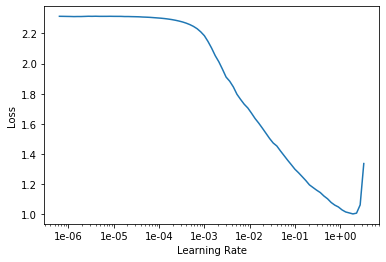

In [35]:
learner.recorder.plot()

In [36]:
# learner.fit(5, lr=0.01, callbacks=[conlleval_metric])
learner.fit_one_cycle(30, 3e-2,
                      metrics=[f1score],
                      callbacks=[
                          SaveModelCallback(learner, monitor='f1-score', every='improvement', name='best_model'),
                          EarlyStoppingCallback(learner, monitor='valid_loss', min_delta=0.01, patience=10),
                          # conlleval_metric
                      ])

KeyboardInterrupt: 

In [37]:
# learner.save('model_1', return_path=True)

In [38]:
learner.load('best_model')

Learner(data=DataBunch;

Train: LabelList (14861 items)
x: ItemList
[list([29, 8, 68, 113, 207, 1161, 85, 24, 58, 40, 0, 238, 7323, 2, 1081, 33, 804, 6533, 3174, 7041, 7, 209, 2, 29, 8, 0, 108, 85, 40, 394, 238, 193, 18, 0, 953, 13693, 2844, 160, 30, 214])
 list([[182, 126], [37, 137], [183, 191, 98], [182, 15, 171, 98, 101], [71, 16, 76, 98], [98, 101, 47, 98], [98, 158, 56, 34], [182, 76], [182, 16], [34, 79], [56, 98, 0, 182, 95, 0, 18, 15, 62, 98, 101], [136, 121, 98, 101], [34, 158, 86, 16, 0, 71, 146, 98, 158, 0, 18, 15, 62, 98, 101], [0], [183, 158, 16, 168, 130], [182, 168, 98], [37, 15, 81, 98, 101], [158, 137, 98, 101, 0, 158, 191, 86], [37, 15, 69, 0, 34, 158, 83, 98, 101], [182, 15, 171, 98, 101, 0, 71, 16, 76, 98], [183, 143, 121], [34, 158, 168, 0, 101, 16, 164, 16], [0], [182, 126], [37, 137], [158, 176, 16, 0, 34, 120, 146, 98, 158], [37, 164, 98], [98, 158, 56, 34], [34, 79], [34, 72, 97], [136, 121, 98, 101], [182, 83, 98, 101], [29, 164, 16], [0, 0, 0, 0, 0, 0], [37,

In [39]:
learner.validate(dl=learner.data.test_dl, callbacks=[conlleval_metric])

[0.023971697, 86.6779089376054, 85.78104138851802, 86.22714309679584]